# The Wolbachia only QSD

## Abby Barlow, University of Bath
## Ben Adams, University of Bath

Import required libraries

In [1]:
import numpy as np
import sympy as sp
import itertools
from scipy.linalg import expm
import pylab as plt
import matplotlib
from matplotlib.colors import ListedColormap
from scipy.optimize import fsolve
from matplotlib.patches import Rectangle

Import required scripts

In [2]:
import importlib
import Rate_transitions
import Finding_full_Q
import Tridiagonalisation
import Finding_sub_Q
import Lower_block_triangular
import Hughes_model

get_transition = Rate_transitions.get_transition_Hughes
getQ = Finding_full_Q.getQ_Hughes
tridiagonal = Tridiagonalisation.tridiagonal
getQk = Finding_sub_Q.getQk_Hughes
LBTQ = Lower_block_triangular.LBTQ_Hughes_comp
F = Hughes_model.F_hughes

%load_ext autoreload
%autoreload 2

Parameter values

In [3]:
K = 30        # reproductive carrying capacity
d1 = 12/100   # wild-type death rate
d2 = 12/100   # Wolbachia death rate
phi = 85/100    # Wolbachia fitness

v = 10/10      # probability of vertical transmission
u = 10/10     # ratio of unviable offspring produced by an infected male and uninfected female

k = 0.3           # Mosquito competition parameter
h = 0.19*100**k   # Mosquito competition parameter

b1 = round(d1/F(10,h,k,K),2) # wild-type per capita birth rate
b2 = b1*phi                # Wolbachia per capita birth rate

# create a dictionary to store all parameter values
params_dict = {'b1': b1,
              'b2': b2,
              'K': K,
              'd1': d1,
              'd2': d2,
              'v': v,
              'phi': phi,
              'u': u,
              'h': h,
              'k': k
              }

Constructing the full state dictionary

In [4]:
# construct a dictionary that associated an integer index with each possible states, states are stored as an np.array - easier to apply mathematical operations than tuple 
max_pop = 30   # maximum household size
state_dict = {index: np.array((i, j)) for index, (i, j) in enumerate([(i, j) for i in range(max_pop + 1) for j in range(max_pop + 1) if i + j <= max_pop])}

Constructing the full Q matrix

In [5]:
# construct a matrix Q for the transition rate q_ij betweeen states i and j
n_states = len(state_dict)    # number of states

Q = getQ(state_dict,params_dict)  # find Q

Constructing individual dictionaries of the communicating state classes and their respective sub-Q matrices

In [6]:
### S1 corresponds to the wild-type-only states, S2 to the Wolbachia-only and S3 the mixed states
state_dict_S1 = {index: np.array((i, 0)) for index, i in enumerate([i for i in range(1,max_pop + 1)])}
state_dict_S2 = {index: np.array((0, i)) for index, i in enumerate([i for i in range(1,max_pop + 1)])}
state_dict_S3 = {index: np.array((i,j)) for index, (i,j) in enumerate([(i, j) for i in range(1,max_pop + 1) for j in range(1,max_pop + 1) if i + j <= max_pop])}

# finding the sub-q matrices and their respective ordered lists of states in the class
# we will use these list to rearrange Q into lower block triangular form
Q1,key_list1 = getQk(state_dict_S1,state_dict,Q,params_dict)
Q2,key_list2 = getQk(state_dict_S2,state_dict,Q,params_dict)
Q3,key_list3 = getQk(state_dict_S3,state_dict,Q,params_dict)
Q3,key_list3 = getQk(state_dict_S3,state_dict,Q,params_dict)

Constructing the lower block triangular formulation of Q

In [7]:
Q_lower_block_triang, state_dict_relabel = LBTQ(Q,state_dict,state_dict_S1,state_dict_S2,state_dict_S3,max_pop,params_dict)

Finding the eigenvalues and eigenvectors corresponding to the Wolbachia-only states (S2)

In [8]:
evals2, evecs2 = np.linalg.eig(Q2.T)    # eigenvalues and eigenvectors
decay_param2 = np.max([x for x in evals2 if x != 0])     # minimal magnitude eigenvalue
decay_indx2 = np.argmax([x for x in evals2 if x != 0])   # corresponding index

Calculating the Wolbachia-only QSD

In [9]:
uvec = evecs2[:,decay_indx2]          # left eigenvector corresponding to minimal magnitude eigenvalue
quasi_stat_dist2 = uvec/np.sum(uvec)  # normalising to sum to 1
print(quasi_stat_dist2)
np.save('uvec2.npy',quasi_stat_dist2)  # saving the distribution to load into other notebooks

[5.39475404e-02 7.39437737e-02 8.99860721e-02 1.00730943e-01
 1.05293780e-01 1.03686167e-01 9.67699598e-02 8.59867249e-02
 7.30058000e-02 5.94028603e-02 4.64377796e-02 3.49533777e-02
 2.53794406e-02 1.78064298e-02 1.20898922e-02 7.95431230e-03
 5.07745831e-03 3.14800521e-03 1.89762777e-03 1.11321439e-03
 6.36082241e-04 3.54291860e-04 1.92506041e-04 1.02108482e-04
 5.29042805e-05 2.67908523e-05 1.32671896e-05 6.42782178e-06
 3.04776365e-06 1.41437861e-06]


Plotting the Wolbachia-only QSD

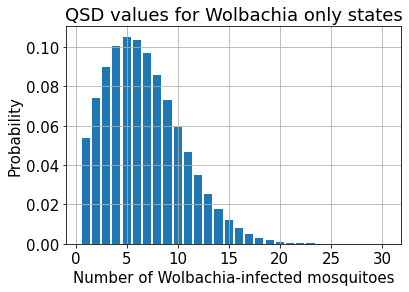

In [12]:
matplotlib.rcParams.update({'font.size': 15}) # font size

values = np.arange(1,31,1)    # number of W-only mosquitoes
plt.bar(values,quasi_stat_dist2)   # plot distribution as bar chart
plt.xlabel('Number of Wolbachia-infected mosquitoes')   # x label
plt.ylabel('Probability')                               # y label
plt.title('QSD values for Wolbachia only states')       # title
plt.grid()  # adds grid
plt.savefig('QSD_wolb.pdf', bbox_inches='tight')  # save figure